# Word Vectors from Scratch

## Packages

In [461]:
import torch
import torch.nn as nn

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import deque
import string
import matplotlib.pyplot as plt
import random

In [458]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/eno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/eno/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Importing our corpus and preprocessing

In [470]:
# Example usage
file_path = 'combined_articles.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

In [471]:
def extract_unique_words(text):
    # Lowercase and tokenize the text
    text = text.lower()
    words = word_tokenize(text)

    # Remove punctuation
    words = [word for word in words if word.isalpha()]

    # Count the number of words and unique words
    print("# of words in the text: ", len(words))

    unique_words = sorted(set(words))
    print("# of unqiue words in the text: ", len(unique_words))

    return unique_words

In [472]:
unique_words = extract_unique_words(text)

# of words in the text:  259101
# of unqiue words in the text:  20355


In [473]:
def generate_cbows(text, window_size):
    # Lowercase and tokenize the text
    text = text.lower()
    words = word_tokenize(text)

    # Remove punctuation
    words = [word for word in words if word.isalpha()]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Create CBOW pairs with a given window size
    cbows = []
    for i, target_word in enumerate(words):
        context_words = words[max(0, i - window_size):i] + words[i + 1:i + window_size + 1]
        if len(context_words) == window_size * 2:
            cbows.append((context_words, target_word))
    return cbows

In [474]:
# Create skip-grams
cbows = generate_cbows(text, window_size=3)

# Display the results
for context_words, target_word in cbows[:3]:
    print(f'Target Word: {context_words}, Context Word: {target_word}')

Target Word: ['china', 'chinese', '中国', 'zhōngguó', 'officially', 'people'], Context Word: pinyin
Target Word: ['chinese', '中国', 'pinyin', 'officially', 'people', 'republic'], Context Word: zhōngguó
Target Word: ['中国', 'pinyin', 'zhōngguó', 'people', 'republic', 'china'], Context Word: officially


In [475]:
len(cbows)

154594

In [476]:
def one_hot_encoding(word, unique_words):
    encoding = [1 if word == w else 0 for w in unique_words]
    return torch.tensor(encoding, dtype=torch.float32)

In [477]:
# Create one-hot encodings for each word
one_hot_encodings = {word: one_hot_encoding(word, unique_words) for word in unique_words}
one_hot_encodings

{'a': tensor([1., 0., 0.,  ..., 0., 0., 0.]),
 'aaa': tensor([0., 1., 0.,  ..., 0., 0., 0.]),
 'aactas': tensor([0., 0., 1.,  ..., 0., 0., 0.]),
 'aba': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abacha': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abacus': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abadan': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abajo': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abandoned': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abandoning': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abandonment': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abangan': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abate': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abaya': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abaza': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abazas': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abbas': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abbasid': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abbasids': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'abbreviated': tensor([0., 0.,

In [478]:
# Convert CBOW pairs to vector pairs
cbow_vector_pairs = [([one_hot_encodings[word] for word in context_words], one_hot_encodings[target_word]) for context_words, target_word in cbows]

In [479]:
cbow_vector_pairs[0][0] # contains the 6 context word one-hot encoded vectors

[tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.])]

In [480]:
cbow_vector_pairs[0][1] # contains the center word as one-hot encoded vector

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [481]:
# Sum the context vectors to get a single context vector
cbow_vector_pairs = [(torch.sum(torch.stack(context_vectors), dim=0), target_vector) for context_vectors, target_vector in cbow_vector_pairs]

In [482]:
cbow_vector_pairs[0]

(tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

In [483]:
# Shuffle pairs before training
cbow_vector_pairs = random.sample(cbow_vector_pairs, len(cbow_vector_pairs))

## Naive Word2Vec Model

In [484]:
class NaiveWord2Vec(nn.Module):

    def __init__(self, VOCAB_SIZE, VECTOR_DIM, random_seed) -> None:
        super().__init__()

        torch.manual_seed(random_seed)
        self.vocab_size = VOCAB_SIZE
        self.vector_dim = VECTOR_DIM
        self.W1 = nn.Parameter(data=torch.randn(self.vocab_size, self.vector_dim), requires_grad=True)
        self.W2 = nn.Parameter(data=torch.randn(self.vector_dim, self.vocab_size), requires_grad=True)

    def forward(self, X) -> torch.tensor:
        X = X @ self.W1
        X = X @ self.W2

        return X

In [491]:
VOCAB_SIZE = len(unique_words)
VECTOR_DIM = 5
random_seed = 0

## Training the model

In [496]:
model = NaiveWord2Vec(VOCAB_SIZE, VECTOR_DIM, random_seed)

In [497]:
train_cbow_vector_pairs = cbow_vector_pairs[:int(len(cbow_vector_pairs)*0.9)]
val_cbow_vector_pairs = cbow_vector_pairs[int(len(cbow_vector_pairs)*0.9):]

In [498]:
def train_model(model, train_set, val_set, epochs, learning_rate, verbose=False):

    # Create the loss function
    loss_fn = nn.CrossEntropyLoss()
    # Create the optimizer object
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    # Log the loss values
    train_set_loss_log = []
    validation_set_loss_log = []

    for epoch in range(epochs):
        if verbose: print("Epoch: ", epoch)
        # Training mode on
        model.train()
        total_train_loss = 0.0
        num_train_batches = 0

        for input_vector, target_vector in train_set:

            y_train_logits = model(input_vector)
            train_loss = loss_fn(y_train_logits, target_vector)
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            total_train_loss += train_loss.item()
            num_train_batches += 1            

        # Calculate average training loss for the epoch
        average_train_loss = total_train_loss / num_train_batches
        train_set_loss_log.append(average_train_loss)

        # Eval mode on
        model.eval()            
        total_validation_loss = 0.0
        num_validation_batches = 0

        with torch.inference_mode():
            for input_vector, target_vector in val_set:
                # Evaluate the validation loss
                y_val_logits = model(input_vector)
                validation_loss = loss_fn(y_val_logits, target_vector)

                total_validation_loss += validation_loss.item()
                num_validation_batches += 1
        
        # Calculate average validation loss for the epoch
        average_validation_loss = total_validation_loss / num_validation_batches
        validation_set_loss_log.append(average_validation_loss) 

    return model, train_set_loss_log, validation_set_loss_log

In [499]:
model, train_set_loss_log, validation_set_loss_log = train_model(model, train_cbow_vector_pairs, val_cbow_vector_pairs, epochs=2, learning_rate=0.005, verbose=True)

Epoch:  0
Epoch:  1


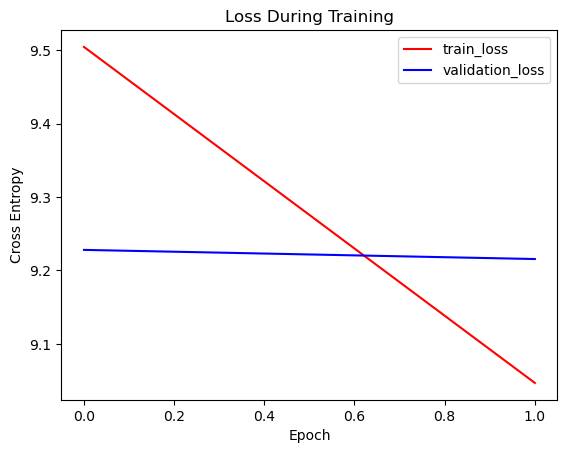

In [500]:
plt.plot(train_set_loss_log, color='red', label='train_loss')
plt.plot(validation_set_loss_log, color='blue', label='validation_loss')

plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
plt.legend()
plt.show()

In [501]:
# Word Vectors
params = list(model.parameters())
word_vectors = params[0].detach()

In [502]:
# Create a dictionary with the same order mapping
word_dict = {word: vector for word, vector in zip(unique_words, word_vectors)}

## Evaluating the Word Vectors

In [523]:
def cosine_similarity(v1, v2):
    return (v1 @ v2) / (torch.norm(v1) * torch.norm(v2))

def most_similar(word, word_dict, top_k=5):
    if word not in word_dict:
        raise ValueError(f"{word} not found in the word dictionary.")

    query_vector = word_dict[word]

    # Calculate cosine similarity with all other words in the dictionary
    similarities = {}
    for other_word, other_vector in word_dict.items():
        if other_word != word:
            similarity = cosine_similarity(query_vector, other_vector)
            similarities[other_word] = similarity

    # Sort the words by similarity in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Get the top-k most similar words
    top_similar_words = sorted_similarities[:top_k]

    return top_similar_words

In [535]:
word_dict

{'a': tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487]),
 'aaa': tensor([ 1.0034, -0.3029, -2.0079, -0.3065, -0.9500]),
 'aactas': tensor([0.8513, 0.9443, 0.4473, 0.8879, 1.4313]),
 'aba': tensor([ 0.6022, -0.2317, -2.2191, -0.6540, -0.5188]),
 'abacha': tensor([ 0.4889, -0.2688, -0.3681,  0.9355,  1.0961]),
 'abacus': tensor([-0.8971, -0.7074,  0.4995,  1.6973,  1.2691]),
 'abadan': tensor([ 0.9463, -0.2081,  0.0211,  0.6666, -0.4914]),
 'abajo': tensor([ 0.2756,  0.3381, -0.4398,  0.6006,  0.1511]),
 'abandoned': tensor([-0.3704, -0.5691,  0.1732, -0.2562,  0.4163]),
 'abandoning': tensor([ 1.9956, -1.7834, -0.3168, -0.0597, -0.3850]),
 'abandonment': tensor([ 0.1024, -0.1393,  0.4223,  0.5612,  0.2158]),
 'abangan': tensor([-0.1411,  0.0525,  0.3468,  1.2792,  3.0063]),
 'abate': tensor([-1.0762, -0.9224,  1.4979, -0.6045, -0.9474]),
 'abaya': tensor([-0.5966,  1.0587,  1.0482,  0.0663,  2.0810]),
 'abaza': tensor([-0.7900,  0.3363, -0.9951, -0.2328, -0.7978]),
 'abazas': tensor

In [532]:
most_similar('president', word_dict)

[('baháʼí', tensor(0.9973)),
 ('geometrical', tensor(0.9928)),
 ('guerrillas', tensor(0.9926)),
 ('anointing', tensor(0.9870)),
 ('led', tensor(0.9868))]

In [524]:
cosine_similarity(word_dict['king'], word_dict['queen'])

tensor(0.7967)

In [527]:
cosine_similarity(word_dict['king'], word_dict['car'])

tensor(-0.4596)